In [ ]:
#
# General tools
#
import glob
import os
import shutil
import sys
import random
import urllib
import zipfile
#
# Astropy tools
#
from astropy.coordinates import match_coordinates_sky, SkyCoord
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
from astropy.stats import mad_std
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.table import Table, Column, vstack
from astropy.visualization import LogStretch, LinearStretch, PercentileInterval, ManualInterval
#
# Pandas
#
import pandas as pd
#
# JWST models
#
# !pip install jwst
# from jwst import datamodels, associations
# from jwst.datamodels import ImageModel, dqflags
#
# Matplotlib tools
#
from matplotlib import style, pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
#
# Numpy library
#
import numpy as np
#
# Photutils library and tools
#
# import photutils
# from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
# from photutils import Background2D, MedianBackground, ModeEstimatorBackground, MMMBackground
#
# Scipy tools
#
from scipy import stats
from scipy.interpolate import CubicSpline
#
# Use 90% of the window width
#
from IPython.core.display import display, HTML
display(HTML(""))
#
# Remove Warnings
#
import warnings
warnings.filterwarnings('ignore')
#
# Font params
#
font = {'weight': 'regular', 
        'size': 16}
font2 = {'weight': 'regular', 
        'size': 12}

In [ ]:
#https://jwst-docs.stsci.edu/jwst-near-infrared-camera
#https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-performance/miri-point-spread-functions
psf_fwhm_asecs = [0.064,0.097, 0.109,0.118,0.269,0.328,0.375,0.674] 

z=0.00502
days = 357.12
delta_day = (357.12-255)*1.0/100

In [ ]:
# Functions

# Function to CHECK IF RAS AND DECS ARE IN AN IMAGE
def check_in_image(SNras, SNdecs, SNnames, SNtypes, GalaxyImg):
    
#     for i in range(len(SNnames)):
#         if SNnames[i] == "SN1983V":
#             SNtypes[i] = "Ic"
    
    hdulist = pyfits.open(GalaxyImg)
    map = hdulist[1].data
    wcs = WCS(hdulist[1].header, naxis=0)
    #print(wcs._naxis)
    coords_arr = np.column_stack((SNras, SNdecs)) # ras and decs now [ra,dec]
    pix_x, pix_y = wcs.wcs_world2pix(SNras,SNdecs,0)

    #use world coordinates of all SNe to see if any fall in image (our version of footprint_contains)
    naxis = wcs._naxis #size of image
    naxis1 = hdulist[1].header['NAXIS1']
    naxis2 = hdulist[1].header['NAXIS2']
    is_in_x = (pix_x >= 0) & (pix_x <= naxis1-1) #because of 0-indexing
    is_in_y = (pix_y >= 0) & (pix_y <= naxis2-1)
        
    #get the name, ra, and dec of the SNe that fall in image
    #boolean array indexing (gives back array of Trues and Falses)
    #we are pulling out the SNe that are True and assigning them to own arrays
    name_in_image = np.array(SNnames)[is_in_x & is_in_y]
    type_in_image = np.array(SNtypes)[is_in_x & is_in_y]
    ra_in_image = np.array(SNras)[is_in_x & is_in_y]
    dec_in_image = np.array(SNdecs)[is_in_x & is_in_y]

    x_coord = np.array(pix_x)[is_in_x & is_in_y]
    y_coord = np.array(pix_y)[is_in_x & is_in_y]  
    
    c_delt = hdulist[1].header['CDELT1']
    dist = 17.69 * 10**6 # Handcoded just for 1566 for now until I know how to find this in file
    theta1kpc = np.arctan((1000./dist)*(180./np.pi)) # theta for 1kpc scalebar
    theta100pc = np.arctan((100./dist)*(180./np.pi)) # theta for 1kpc scalebar

    return (name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord, map, naxis1, naxis2, c_delt, dist, theta1kpc, theta100pc)


In [5]:
# grab list of files and SN data

# prefix = "/home/maykerchen.1/Desktop/"
# prefix = "/Users/mayker.1/Desktop/"
prefix = "/Users/nessmayker/Desktop/"

fileList = prefix + "SNeJWST/Data/filelist1566.txt"
fileNames = np.genfromtxt(fileList, dtype=str, unpack=True, usecols=(0))
fileNames = [prefix + "JWSTLargeFiles/ngc1566_v0p6alpha/" + x for x in fileNames]

SNname = "SN2021aefx"
SNtype = "Ia"
SNra   = 64.9725
SNdec  = -54.94808055555555


In [6]:
# set up plots & wcs information.
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.wcs import WCS
plots, wcss, hdus, names, types, ras, decs, xs, ys, maps, nax1s, nax2s, cds, dist = [],[],[],[],[],[],[],[],[],[],[],[],[],[]
cdas,scalebars, cutoutsbs =[],[],[]

for i in range(len(fileNames)):
    if os.path.isfile(fileNames[i]):
        ns, ts, rs, ds, xcs, ycs, ms, n1s, n2s, cd, d, tkpc, tpc = check_in_image(SNra, SNdec, SNname, SNtype, 
                                                                                  fileNames[i])
        names.append(ns)
        types.append(ts)
        ras.append(rs)
        decs.append(ds)
        xs.append(xcs)
        ys.append(ycs)
        maps.append(ms)
        nax1s.append(n1s)
        nax2s.append(n2s)
        cds.append(cd)
        dist.append(d)
        JWST_hdu = pyfits.open(fileNames[i])
        hdus.append(JWST_hdu)
        JWST_map = JWST_hdu[1].data
        plots.append(JWST_map)
        wcss.append(WCS(JWST_hdu[1].header, naxis=2))
        cdelt_as = cd * 3600
        cdas.append(cdelt_as)
        t_as     = tkpc  * 3600
        t_as_cutout = tpc *  3600
        t_as = np.round(t_as,1)
        t_as_cutout =  np.round(t_as_cutout,1)
#         cdelt_pc = d * np.tan(cd*np.pi/180)       
#         sb = ScaleBar(cdelt_pc,"m",dimension="si-length",label="1 kpc",length_fraction=None,fixed_value=1000,
#                       location="lower right",color='white',pad=None, box_alpha=0, font_properties=font, scale_loc = None)
        sb = ScaleBar(cdelt_as,"''",dimension="angle",label="1 kpc",length_fraction=None,fixed_value=t_as,
                      location="lower left",color='black',pad=0.2, box_alpha=0.7, font_properties=font, scale_loc = None)
        scalebars.append(sb)
        sb_co = ScaleBar(cdelt_as,"''",dimension="angle",label="100 pc",length_fraction=None,fixed_value=t_as_cutout,
                      location="lower left",color='black',pad=0.2, box_alpha=0.7, font_properties=font2, scale_loc = None)
        cutoutsbs.append(sb_co)

print(types)

[array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2')]


In [7]:
# set up legend labels

legendLabels = []

for i in range(len(names)):
    legendlabel = []
        
    if len(names[i]) > 1:
        for k in range(len(names[i])):
            if types[i][k] == 'unclassified' or types[i][k] == 'Unclassified':
                typelabel = names[i][k] + ' '  + types[i][k]
            else:
                typelabel = names[i][k] + ' Type '  + types[i][k]
            legendlabel.append(typelabel)
    else:
        if types[i][0] == 'unclassified' or types[i][0] == 'Unclassified':
            legendlabel.append(names[i][0] + ' '  + types[i][0]) 
        else:        
            legendlabel.append(names[i][0] + ' Type '  + types[i][0])
    legendLabels.append(legendlabel)

print(legendLabels)


[['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia']]


In [8]:
# set up plot specifics
from matplotlib.patches import Circle

markerShapes = ["o", "s", "p", "D", "X", "H", "v"]
markerSizes  = [210,150,310,150,330,310,350]
markerEdges  = [410,350,610,350,630,610,650]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

#        1,       2,      3,       4,        5,       6,       7,     8
vmm = [[0.1,40],[0.1,40],[0.1,40],[0.1,40],[0.5,35],[0.5,35],[0.5,35],[0.5,35]]

# vmm = [[np.percentile(x,0.1),np.percentile(y,0.99)] for x,y in vmm]
imgs = ["nircam_clear-f200w", "nircam_clear-f300m", "nircam_clear-f335m",
        "nircam_clear-f360m","miri_f770w", "miri_f1000w", "miri_f1130w", "miri_f2100w"]
titles = ["F200W", "F300M", "F335M",
        "F360M", "F770W", "F1000W", "F1130W", "F2100W"]

In [9]:
# get nebular mask ready
# from reproject import reproject_interp

# ngc1365NebFile = '../Data/NGC1566_nebulae_mask_V2.fits'

# neb_hdu = pyfits.open(ngc1365NebFile)
# neb_map = neb_hdu[0].data
# neb_wcs = WCS(neb_hdu[0].header, naxis=2)
# plt.imshow(neb_map)


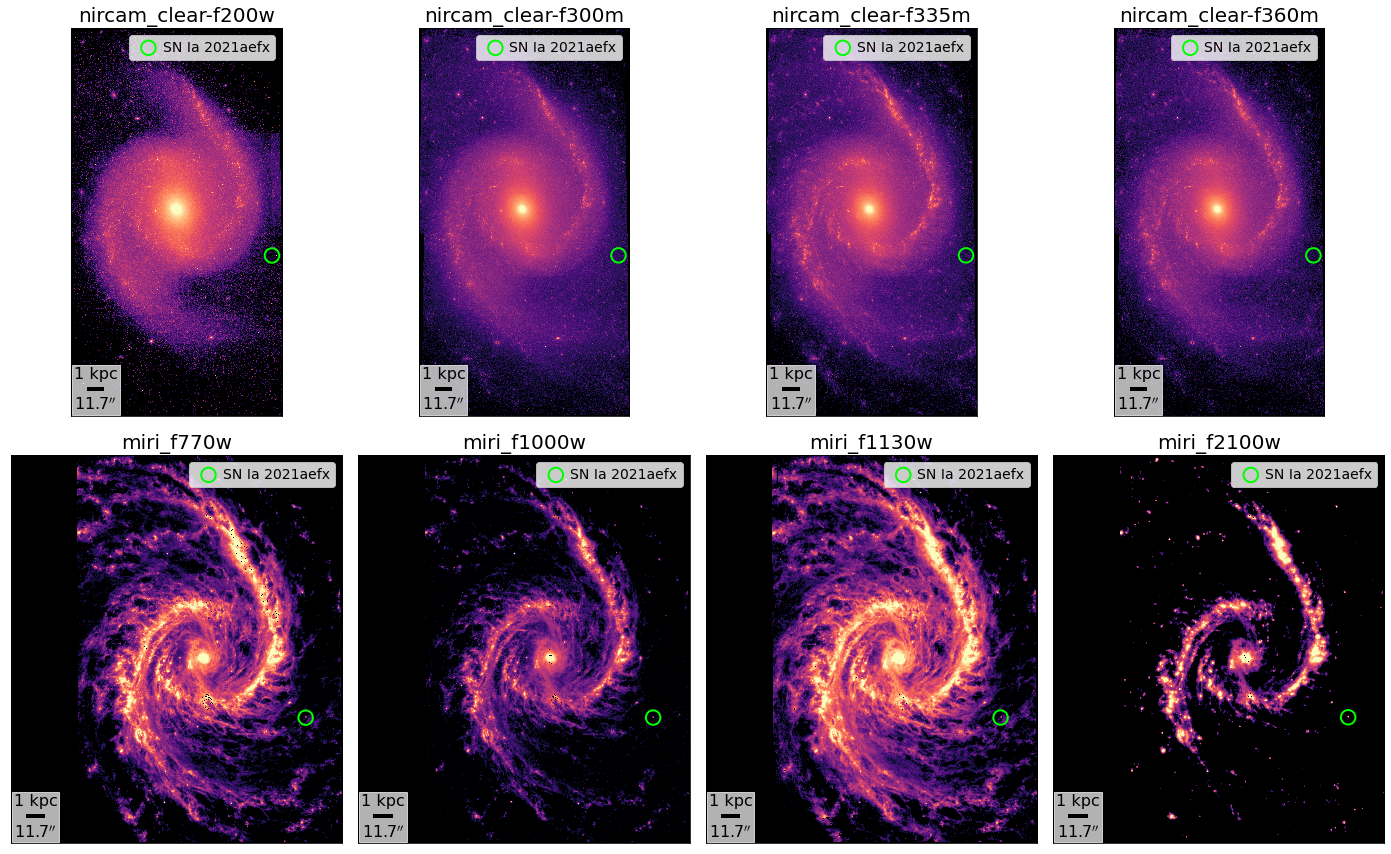

In [10]:
# make multipanel plot  

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 4
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(30, 15))

for plot in plots:
    
#     neb_arr, neb_ftp = reproject_interp(neb_hdu, hdus[m][1].header)

    
    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    
    logplot = np.log10(plot)
    pos = axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", 
                     origin = "lower", interpolation = "nearest",
                    vmin=np.log10(vmm[m][0]), vmax=np.log10(vmm[m][1]))
    axs[i][j].set_title(imgs[m], fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
      
    for n in range(len(decs[m])):
#         axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerEdges[n], zorder=2)
        axs[i][j].scatter(xArr[n], yArr[n], facecolor = "none", marker = markerShapes[n], s = markerSizes[n], 
                          edgecolor="lime", linewidth=2, label = "SN Ia 2021aefx", zorder = 2)
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)
    axs[i][j].add_artist(scalebars[m])
#     axs[i][j].arrow(0.5, 0.5, 0.05, 0.05, color="white")
#     axs[i][j].imshow(neb_arr, alpha = 0.2)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m+=1

plt.subplots_adjust(wspace=-0.45, hspace=0.1)
plt.show()
fig.savefig("../Figures/NGC1566allPanels.png", dpi=300)
plt.close()


<Figure size 432x288 with 0 Axes>

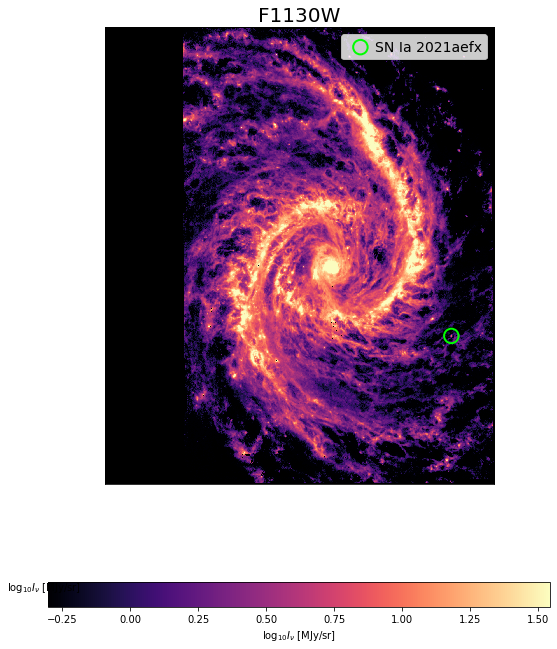

In [11]:
# make F1130W plot 
plt.clf()
m=6
plot = plots[m]
ra,dec = ras[m],decs[m]
wcs=wcss[m]
vmins=vmm[m][0]
vmaxs=vmm[m][1]

fig, ax  = plt.subplots(figsize=(9,12))
xArr, yArr = wcs.wcs_world2pix(ra,dec,0)
logplot = np.log10(plot)
pos = ax.imshow(logplot, cmap=current_cmap, aspect="equal", 
                     origin = "lower", interpolation = "nearest",
                    vmin=np.log10(vmins), vmax=np.log10(vmaxs))
# fig.colorbar(pos, orientation="horizontal")

ax.set_title("F1130W", fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
      
ax.scatter(xArr, yArr, facecolor = "none", marker = markerShapes[0], s = markerSizes[0], 
                      edgecolor="lime", linewidth=2, label = "SN Ia 2021aefx", zorder = 2)
ax.legend(loc="best", fontsize=14, handletextpad=0.007)
# ax.add_artist(scalebars[m])

cbar = plt.colorbar(pos,orientation="horizontal",label=r'$\log_{10} I_{\nu}$ [MJy/sr]') # ticks=[]

# cbar.set_ticks([0.1, 1.0, 1.41])
# cbar.set_ticklabels([r"$10^{-1}$", r"$10{^0}$", r"$10^{0.15}$"])


# # cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\log_{10} I_{\nu}$ [MJy/sr]', rotation=0)
import matplotlib.colors as colors
# pcm = ax.pcolor(plot,
#                    norm=colors.LogNorm(vmin=plot.min(), vmax=plot.max()),
#                    cmap='PuBu_r', shading='auto')
# fig.colorbar(pcm, ax=ax, extend='max')


plt.show()
fig.savefig("../Figures/F1130W.png", dpi=300)
plt.close()


In [12]:
# Get angular sizes of interest ready

def findAngSize(sphere, dist):
    """ Finds the angular size in decimal degrees when given the 
        size of the sphere in pc and the
        distance to the galaxy in Mpc
    """
    
    angSizeRad = np.arctan(sphere/(dist*10**6))
    angSize = angSizeRad * (180/np.pi)

    return(angSize)

sphereSizes = [10,200,1000]
angSizes = []

dist_to_1566 = 17.69

ang1 = findAngSize(sphereSizes[0], dist_to_1566)
ang2 = findAngSize(sphereSizes[1], dist_to_1566)
ang3 = findAngSize(sphereSizes[2], dist_to_1566)

angSizes.append([ang1, ang2, ang3])



In [13]:
#subplot padding changes

lft = 0.1
btm = 0.1
rht = 0.99
tp  = 0.7
wsp = 0.45
hsp = 0.5
pd  = 0.5
wpd = 3.0
hpd = 0.4

# plotting code
def makeZooms(rows, columns, images, SNra, SNdec, SNname, SNtype, vmm, size=(10,5), log=True):
    m,n,p =0,0,0 # plot counters for total number, rows, columns
    PLOTS_PER_ROW = columns
    numPanels = int(rows*columns)
    figname = SNname
    figname, axs = plt.subplots(math.ceil(numPanels/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=size)
#     fig = plt.figure(figsize = size)

    for j in range(len(images)): # counter to count wavelengths

        #set up data to use astropy's cutout2D to plot subsections of galaxy map
        data = plots[j]
        if log == True:
            data = np.log10(data)
        wcs=wcss[j]

        halfBox = angSizes[0][2] # 1000 pc in decimal degrees
        #cutout2D needs skycoord position to carry units
        ra, dec = Angle(SNra * u.degree), Angle(SNdec * u.degree)
        raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
        position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
        #size = u.Quantity((20,20), u.arcsec) #size is size of box in arcsec 
        size = u.Quantity((halfBox,halfBox), u.degree) #size is size of box in arcsec 
        # make 2D cutout, will assign a new wcs to cutout to keep track of coords
        cutout = Cutout2D(data, position, size, wcs) 
        # use this new wcs when converting to pixels to add additional details to plot
        xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
        y1 = yval * 0.2
        x1 = xval * 0.1

        titleStr = images[j]

        # make plot
#         axs[m][n] = fig.add_subplot(rows,columns,p+1,projection = cutout.wcs)
        if rows == 1:
            
            axs[n].set_title(titleStr, fontsize=14)    
            axs[n].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
                          interpolation = "nearest", zorder = 0, vmin=np.log10(vmm[m][0]), vmax=np.log10(vmm[m][1]))
#             axs[n].scatter(xval, yval, color = "black", marker ="o", s = 60, zorder=2)
            axs[n].scatter(xval, yval, facecolor = 'none', marker = "o", s = 80, edgecolor="lime",linewidth=2,zorder = 2)
            axs[n].set_xlabel("")
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].tick_params(axis = "both", direction = "in", length = 0)
            axs[n].axis('off')
            axs[n].axhline(y1,0.1,0.2, color="white")
            axs[n].text(x1, yval * 0.4, "100pc", color="white", horizontalalignment = 'left', verticalalignment = 'top')
#             axs[n].add_artist(cutoutsbs[j])

            n+=1
            p +=1
            
        else:
            axs[m][n].set_title(titleStr, fontsize=14)    
            axs[m][n].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
                             interpolation = "nearest", zorder = 0, vmin=np.log10(vmm[m][0]), vmax=np.log10(vmm[m][1]))
#             axs[m][n].scatter(xval, yval, color = "black", marker ="o", s = 60, zorder=2)
            axs[m][n].scatter(xval, yval, facecolor = 'none', marker = "o", s = 80, edgecolor="lime",linewidth=2,zorder = 2)
            axs[m][n].set_xlabel("")
            axs[m][n].set_xticks([])
            axs[m][n].set_yticks([])
            axs[m][n].tick_params(axis = "both", direction = "in", length = 0)
            axs[m][n].axis('off')
            axs[m][n].axhline(y1,0.1,0.2, color="white")
            axs[m][n].text(x1, yval * 0.4, "100pc", color="white", horizontalalignment = 'left', verticalalignment = 'top')
#             axs[m][n].add_artist(cutoutsbs[j])

            n+=1
            if n%PLOTS_PER_ROW==0:
                m+=1
                n=0
            p +=1
        figname.suptitle(SNname + ": " + SNtype, fontsize=20)
        plt.subplots_adjust(left = lft, bottom = btm, right = rht, top = tp, wspace = wsp, hspace = hsp)
    plt.tight_layout(pad=pd, w_pad=wpd, h_pad=hpd)
#     figname.savefig("../Figures/NGC1566_Zooms_" + SNname + ".pdf", dpi=300)
    plt.show()


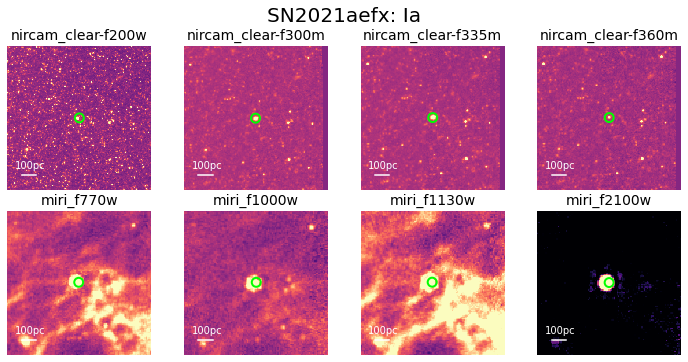

In [14]:
# Zoom plot
makeZooms(2,4, imgs, SNra, SNdec, SNname, SNtype,vmm, log=False)          #SN2021aefx


In [15]:
psfFiles = ["NIRCam_PSF_filter_F200W.fits","NIRCam_PSF_filter_F300M.fits",
            "NIRCam_PSF_filter_F335M.fits","NIRCam_PSF_filter_F360M.fits","MIRI_PSF_filter_F770W.fits","MIRI_PSF_filter_F1000W.fits","MIRI_PSF_filter_F1130W.fits",
            "MIRI_PSF_filter_F2100W.fits"]
psfFiles = ["../Data/JWST_PSF/" + x for x in psfFiles]


In [16]:
# # Set up photutils and apertures within cutout.

# def getPhot(m,coords1,coords2,rad,rin, rout, img,cdelt,psf,errRangeVals):
#     xval = coords1[0]
#     yval = coords1[1]

#     # Statistical noise of whole map
#     Xmin = errRangeVals[0] # read in max and min coord ranges
#     Ymin = errRangeVals[1]
#     Xmax = errRangeVals[2]
#     Ymax = errRangeVals[3]
    
#     # randomly assign 100 apertures within the range using same radius as measurement
#     xs = [random.randint(Xmin, Xmax) for p in range(0,100)]
#     ys = [random.randint(Ymin, Ymax) for p in range(0,100)]
#     errPos = np.transpose((xs, ys)) 
#     errAps = CircularAperture(errPos, r=rad)

#     # make table
#     err_table = aperture_photometry(plots[m], errAps) 
#     errApsSums = err_table['aperture_sum']
#     statErr = mad_std(errApsSums)    # measure scatter of apertures mad_Std numpy    
        
#     # Set cutout size based on filter being used
#     if m <= 3:
#         halfBox = angSizes[0][1] # 200 pc in decimal degrees for NIRCam
        
#     else:
#         halfBox = angSizes[0][2] # 1000 pc in decimal degrees for MIRI
    
#     data = plots[m]
#     # data = np.log10(data)
#     wcs=wcss[m]

#     #cutout2D needs skycoord position to carry units
#     ra, dec = Angle(SNra * u.degree), Angle(SNdec * u.degree)
#     raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
#     position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
#     size = u.Quantity((halfBox,halfBox), u.degree) #size is size of box in arcsec 
#     # make 2D cutout, will assign a new wcs to cutout to keep track of coords
#     cutout = Cutout2D(data, position, size, wcs) 

#     xvalAct, yvalAct = cutout.wcs.wcs_world2pix(ra,dec, 0)
# #     print(xvalAct,yvalAct)
    

#     # get ra and dec of aperture center pixels
#     ra,dec=cutout.wcs.wcs_pix2world(xval,yval, 0)
#     ra, dec = Angle(ra * u.degree), Angle(dec * u.degree)
#     raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad   
#     #make new cutout so that image is centered on aperture
#     position = SkyCoord(ra, dec) #position is center, use ra & dec of SN location
#     cutout = Cutout2D(data, position, size, wcs) 
    
#     xval = coords2[0]
#     yval = coords2[1]
    
#     #convert apertures to decimal degrees
#     angRad = rad * cdelt 
# #     print("radius=",angRad,"decimal degrees")
#     rad_asec = angRad * 3600.
#     print("radius=",rad_asec,"arcseconds")
# #     print("ra,dec =", ra,dec)
    
#     # Photutils Photometry
#     #Get apertures set up
#     positions = np.transpose((xval, yval)) 
#     apertures = CircularAperture(positions, r=rad)
#     annulus_apertures = CircularAnnulus(positions, r_in=rin, r_out=rout)

#     # make table
#     phot_table = aperture_photometry(cutout.data, apertures)  

#     #Subtract background
#     aperstats = ApertureStats(cutout.data, annulus_apertures)
#     bkg_mean = aperstats.mean
#     aperture_area = apertures.area_overlap(cutout.data)
#     total_bkg = bkg_mean * aperture_area
#     phot_bkgsub = phot_table['aperture_sum'] - total_bkg

#     #add to table
#     phot_table['total_bkg'] = total_bkg
#     phot_table['aperture_sum_bkgsub'] = phot_bkgsub
    
    
#     #Find aperture correction
#     psf_hdu = pyfits.open(psf) #open psf file
#     psf_map = psf_hdu[0].data
# #     total_flux = np.sum(psf_map) 
# #     print("PSF Total Flux:",total_flux)
#     pix_scale = psf_hdu[0].header['PIXELSCL'] #find pixel scale 
#     naxis1 = psf_hdu[0].header['NAXIS1']/2.0
#     naxis2 = psf_hdu[0].header['NAXIS2']/2.0

#     peak = np.argmax(psf_map) # find peak of psf
# #     print("Peak index:", peak)
#     pixels = rad_asec / pix_scale # convert aperture radius used to their pixel scale
#     peak_position = np.transpose((naxis1, naxis2)) 
#     PSFaperture = CircularAperture(peak_position, r=pixels) # place aperture on peak and measure flux out to radius
#     acorr_table = aperture_photometry(psf_map, PSFaperture) 
#     acorr = acorr_table["aperture_sum"] # determine aperture correction
#     new_phot = phot_bkgsub / acorr
#     phot_table['acorr'] = acorr #add to table
#     phot_table['Flux_corr'] = new_phot
    
    
#     #format and print table
#     for col in phot_table.colnames:  
#         phot_table[col].info.format = '%.8g'  # for consistent table output
#     print(phot_table) 
 
#     # use this new wcs when converting to pixels to add additional details to plot
#     # xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
#     y1 = yval * 0.2
#     x1 = xval * 0.1

#     plt.imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
#                   interpolation = "nearest", zorder = 0, vmin=np.percentile(cutout.data,1), vmax=np.percentile(cutout.data,99))
#     # plt.scatter(xval, yval, facecolor = 'none', marker = "o", s = 80, edgecolor="lime",linewidth=2,zorder = 2)
#     apertures.plot(color='lime',zorder=2, lw=2)
#     annulus_apertures.plot(color='cyan',zorder=2,lw=2)

#     if m <= 3:
#         plt.axhline(y1,0.1,0.2, color="white",lw=2)
#         plt.text(xval*0.16, yval * 0.15, "20pc", color="white", horizontalalignment = 'left', verticalalignment = 'top',fontsize=14)
#     else:
#         plt.axhline(yval * 1.8,0.1,0.2, color="white",lw=2)
#         plt.text(xval*0.14, yval * 1.75, "100pc", color="white", horizontalalignment = 'left', verticalalignment = 'top', fontsize=14)
        
#     plt.axis('off')
# #     plt.colorbar( orientation="horizontal")
#     plt.title(titles[m], fontsize = 20)
#     plt.savefig(imgs[m],transparent = True, dpi=300)
#     plt.show()
#     print(xval,yval,rad,ra,dec,phot_table["Flux_corr"][0],img, angRad,acorr, statErr)
#     return(xval,yval,rad,ra,dec,phot_table["Flux_corr"][0],img, angRad,acorr, statErr)


In [17]:
#do first image getPhot(img,ra=,dec=,rad=7)

# minMax = [[1640,3550,2180,4032],[1640,3550,2180,4032],[1640,3550,2180,4032],[1640,3550,2180,4032],[1496,1853,1782,2081],[1496,1853,1782,2081],[1496,1853,1782,2081],[1496,1853,1782,2081]]
minMax = [[1640,3350,2180,3832],[1640,3550,2180,4032],[1640,3550,2180,4032],[1640,3550,2180,4032],[1496,1853,1782,2081],[1496,1853,1782,2081],[1496,1853,1782,2081],[1496,1853,1782,2081]]

cords1 = [[32.5,36.5],[18,17.5],[18.25,18.25],[18.4,18.75],[49.8,52.8],[50.1,51.5],[49.75,52.362244],[50,52.362244]]
cords2 = [[37.347, 37.760],[17.604, 17.515],[18.016, 18.303],[18.016, 18.303],[51.647, 52.362],[52.283, 52.344],[51.75, 52.439],[51.971, 52.165]]

# radii = [6.5,5,5,5,7,8,8.5,8.5]
radii = [2*x/y for x,y in zip(psf_fwhm_asecs,cdas)]

r_in = [x*1.5 for x in radii]
r_out = [x*3 for x in radii]

xvals,yvals,rads,ras,decs,fcs,imgName, angRads,acorrs,statErrs = [],[],[],[],[],[],[],[],[],[]
for i in range(len(imgs)):
    xval,yval,rad,ra,dec,fc,img,angRad,acorr,statErr = getPhot(i,cords1[i],cords2[i],radii[i],r_in[i],r_out[i],imgs[i],cds[i],psfFiles[i],minMax[i])
    
    xvals.append(xval)
    yvals.append(yval)
    rads.append(rad)
    ras.append(ra)
    decs.append(dec)
    fcs.append(fc)
    imgName.append(img)
    angRads.append(angRad * 3600)
    acorrs.append(acorr)
    statErrs.append(statErr)
    
    
statErrs = [(x/y) for x,y in zip(statErrs, acorrs)]# aperture correct stats errs    
ras  = [np.round(x,6) for x in ras]
decs = [np.round(x,6) for x in decs]
angRads = [np.round(x,3) for x in angRads]
acorrs = [np.round(x,3) for x in acorrs]



radius= 0.128 arcseconds


NameError: name 'ApertureStats' is not defined

In [18]:
# convert the cdelt in decimal degrees to steradian
def find_mJy(fcs,cdelt,radius): #fc is flux corrected [MJy/str]
    flux = []
    for i in range(len(cdelt)):
        sr_per_pix = cdelt[i]**2 * (np.pi/180.)**2
        total_sr = sr_per_pix #  times radius? times area? 
        flux.append(fcs[i] * 10**9 * total_sr) # convert from Mega to milli (* 10^9)
    return(flux)
#flux in Jy
NessFlux = find_mJy(fcs,cds,rads)
statErrs = find_mJy(statErrs,cds,rads)
NessFlux = [x*10**3 for x in NessFlux]
NessFlux = [np.round(x,2) for x in NessFlux]
fcs = [np.round(x,0) for x in fcs]
statErrs = [x*10**3 for x in  statErrs]
statErrs = [np.round(x,2) for x in statErrs]

NessFlux

IndexError: list index out of range

In [ ]:
# convert flux to solar Luminosity

def find_Lum(flux_uJy,lambda_0,delta_lambda,d_Mpc):

    m_per_Mpc = 3.086 * 10**22     # [m / Mpc]
    ergs_per_Lsun = 3.826 * 10**33 # [erg s-1 / L_sun]
    ergs_per_Jy = 10**(-19)        # [erg⋅s−1⋅m−2⋅Hz−1 / Jy]
    c = 299792458                  # [m/s]
    m_per_micron = 10**(-6)        # [m / micron]

    Nu, Del_Nu, Nu_Lnu, Delta_Lnu = [],[],[],[]
    
    for i in range(len(flux_uJy)):
        flux_Jy   = flux_uJy[i] * 10**(-6) # [Jy]
        flux_ergs = flux_Jy * ergs_per_Jy   # [erg⋅s−1⋅m−2⋅Hz−1]
        L_nu = 4 * np.pi * (d_Mpc)**2 * (m_per_Mpc)**2 * flux_ergs * (1+z)**3 # [erg]
        nu_0 = c/(lambda_0[i] * m_per_micron) # [1/s]
        
        delta_nu = np.abs(c / ((lambda_0[i] + delta_lambda[i]/2.) * m_per_micron) - 
                          c / ((lambda_0[i] - delta_lambda[i]/2.) * m_per_micron))   # [1/s]
                
        Nu_L_nu = L_nu * nu_0 # [ergs /s]        
        Delta_nu_L_nu = L_nu * delta_nu # [ergs /s] 
        Nu.append(nu_0 * 10**-13)
        Del_Nu.append(delta_nu * 10**-13)
        Nu_Lnu.append(Nu_L_nu / ergs_per_Lsun * 10**-5)
        Delta_Lnu.append(Delta_nu_L_nu / ergs_per_Lsun * 10**(-5))

    Nu_Lnu = [np.round(x,3) for x in Nu_Lnu]
    Delta_Lnu = [np.round(x,3) for x in Delta_Lnu]
    Nu = [np.round(x,3) for x in Nu]
    Del_Nu = [np.round(x,3) for x in Del_Nu]    
    return(Nu, Del_Nu,Nu_Lnu, Delta_Lnu)



In [ ]:
delta_lambda = [0.461,0.318,0.347,0.372,2.2,2.0,0.7,5.0] #[microns]
lambda_0 = [1.990,2.996,3.365,3.621,7.7,10.0,11.3,21.0] #[microns]

Nu, Del_Nu, NuLnu, DeltanuLnu = find_Lum(NessFlux, lambda_0,delta_lambda, 17.69)

Nu_Fnu = [x*y*10**10 for x,y in zip(Nu,NessFlux)]
print(Nu_Fnu)
print(Nu)
print(NessFlux)

In [ ]:
#Compare fluxes and assign uncertainties

objects = ["PAH, broadband imaging","silicate, broadband imaging","PAH, broadband imaging","broadband imaging",
           "general purpose","Water Ice","PAH, CH4","brown dwarfs, planets, continuum"]
#NC200, NC300, NC335, NC365, MIRI770, MIRI1000, MIRI1130, MIRI2100
NilsFlux = [0.020820914,0.013263861,0.018101258,0.004821749,0.252278372,0.154858533,0.152812559,0.430785756]
ErikFlux = [0.02029, 0.01159, 0.01711, 0.00433,0.2884, 0.1898, 0.1872, 0.3379]
ErikErrs= [0.00004,0.00006,0.00008,0.00004,0.0003, 0.0002, 0.0003, 0.0003]
KwokMags = [19.97,19.70,19.25,20.87,17.37,17.67,17.51,np.float("nan")]
NilsFlux = [np.round(x*10**3,1) for x in NilsFlux]
ErikFlux = [np.round(x*10**3,1) for x in ErikFlux]

#systematic noise


# [[int(x), y.strip(), z.strip()] for s in inputs for (x, y, z) in [s.split(",")]]

inputs = zip(NessFlux, NilsFlux, ErikFlux)
JWSTcalErr = [x * 0.04 for x in NessFlux]

measErr, systErr = [],[]
for i in range(len(NessFlux)):
    measureUnc = mad_std([NessFlux[i], NilsFlux[i], ErikFlux[i]])
    measErr.append(np.round(measureUnc,5))
    systemicUnc = np.sqrt(JWSTcalErr[i]**2 + measureUnc**2) 
    systErr.append(np.round(systemicUnc,2))

def convertMtoF(M):
    f = 3631 * 10**(-M/2.5) # Flux in Jansky
    f = f * 10**6 # Flux in uJy
    f = np.round(f,3)
    return(f)

def convertFtoM(F):
    F = F*10**-6 # convert flux to Jansky
    M = -2.5 * np.log10(F/3631.)
    M = np.round(M,3)
    return(M)


NessMags = [convertFtoM(x) for x in NessFlux]
print(NessMags)
print(KwokMags)

KwokFlux = [convertMtoF(x) for x in KwokMags]

KwokNu_Fnu = [x*y*10**10 for x,y in zip(Nu,KwokFlux)]


#calculate total photometry error and convert to Mags

totErr = [x+y for x,y in zip(statErrs,systErr)] # add both uncertainties together
fracErr = [x/y for x,y in zip(totErr,NessFlux)] # find fractional uncertainty in flux (mJy)
magErr = [np.abs(-2.5/np.log(10)*x) for x in fracErr]
magErr = [np.sqrt((x/y)**2 + 0.04**2) for x,y in zip(magErr,NessMags)] # sum with Kwok err in quadrature
magDec = [x/delta_day for x in magErr] # get in terms of deltamag/100 days


# [x*y for x,y in zip(fracErr,NessMags)] #convert to fractional mags 

print(totErr)
print(fracErr)
print(magErr)
print(magDec)



fluxTable = Table({"Image":imgName,
                   "Lambda":lambda_0,
                   "Delta Lambda":delta_lambda,
                   "Flux [uJy]": NessFlux,
                   "Statistical Uncertainty [uJy]":statErrs,
                   "Systematic Uncertainty [uJy]":systErr,                   
#                    "R.A. Center [dec deg]":ras,
#                    "Dec Center [dec deg]": decs,
#                    "Aperature Radius [arcsec]": angRads,
#                    "Aperture Sum [MJy/str]": fcs,
                   "Nu L_nu [10^5 L_sun]": NuLnu,
                   "Delta_nu L_nu [10^5 L_sun]": DeltanuLnu})
#                    "Nu [10^13 s^-1]": Nu,
#                    "Delta_nu [10^13 s^-1]": Del_Nu})

fluxTable
ascii.write(fluxTable, "../Data/FluxTable.tex", Writer = ascii.Latex,
            latexdict = {'tabletype': 'table*'}, overwrite=True)


In [ ]:
fluxTable = Table({"Image":imgName,
                   "Aperature Radius [arcsec]": angRads,
                   "Aperature Correction": acorrs,
                   "Flux [mJy]": NessFlux,
                   "Statistical Uncertainty [mJy]":statErrs,
                   "Systematic Uncertainty [mJy]":systErr,
                   "Nu L_nu [10^5 L_sun]": NuLnu,
                   "Delta_nu L_nu [10^5 L_sun]": DeltanuLnu,
                   "Nu [10^13 s^-1]": Nu,
                   "Delta_nu [10^13 s^-1]": Del_Nu})

fluxTable

In [ ]:


fluxTable = Table({"Image":imgName,
                   "Ness Flux [uJy]": NessFlux,
                   "Nils Flux [uJy]": NilsFlux,
                   "Erik Flux [uJy]": ErikFlux,
                   "Kwok Flux [uJy]": KwokFlux})
                  
fluxTable

In [ ]:
# Apply Graur2020 (56)Co decline + H,K declines
dayFac = delta_day
CoDecay100 = 0.975 # Magnitude
KDecay100 = [1.4,1.4]
HDecay100 = [0.3,0.3]

# CoDecayFactor = 0.9975*days/100 # Magnitude
# CoDecayDex    = CoDecayFactor/2.5
# KDecay = 1.4*days/100
# KDecayDex    = KDecay/2.5
# HDecay = 0.3*days/100
# HDecayDex    = HDecay/2.5

K=2.19
H=1.63
dH=0.307
dK=0.390
Krange=[K-dK,K+dK]
Hrange=[H-dH,H+dH]

# Solve for our observed decline rate



In [ ]:
# find declines
print(KwokFlux)
print(NessFlux)
print(KwokMags)
print(NessMags)
change = [np.round((y-x)/dayFac,3) for x,y in zip(KwokMags, NessMags)]
print(change)
print("Filter:",titles)    
print("Decrease/100days:",change)
print("Uncertainties:",magDec)

In [ ]:
lineWave = [1.547, 1.644, 2.218, 2.874, 2.905, 3.120, 3.229, 6.636, 6.985, 7.349, 8.405, 8.991, 
            10.521, 11.002, 11.888]#, 18.804,21.830, 22.93, 24.04,24.07,25.68,25.99]

lineName = ["[Co III]","[Fe II]","[Fe III]","[Fe III]","","[Ni I]","[Fe III]","[Ni II]","[Ar II]",
            "[Ni III]","[Ni IV]","[Ar III]","[Co II]","[Ni III]","[Co III]"]#,"[Co II]","[Ar III]","[Fe III]",
            #"[Fe I]","[Co III]","[Co II]","[Fe II]"]



In [ ]:
# # SED plot 
# colors = ["purple", "mediumpurple", "blue", "green", "yellowgreen", "gold", "orange", "red"]
# err_lambda = [x/2. for x in delta_lambda]
# err_y = [x+y for x,y in zip(statErrs, systErr)]


# fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15, 7),gridspec_kw={'height_ratios': [1, 3]},sharex=True)

# # ax[1].set_ylim(-0.005,2)
# # ax[1].set_xlim(-0.5, 24)
# ax[0].semilogx(lambda_0,change, linestyle = "", marker = "o",markersize = 10,color="purple", label = "Observed")
# # ax[0].errorbar(lambda_0,change, yerr=magDec, ls="", color="purple") # for when I fix the uncertainty
# ax[0].axhline(CoDecay100,label = "56Co")
# ax[0].semilogx(Hrange, HDecay100, linestyle = "--", label = "H-band", color="orange")
# ax[0].semilogx(Krange, KDecay100, linestyle = "-.", label = "K-band", color="green")
# ax[0].set_ylabel(r"$\frac{\Delta Mag}{100 days}$", fontsize=20)
# ax[0].legend(loc="upper right", fontsize = 14, facecolor='white',framealpha=1)
# ax[0].set_xlim(1.3,25)
# ax[0].set_ylim(0.0001,1.5)
# # ax[1].set_xticks([1.5,2,3,3.6,7.7,10,11.3,21])
# # ax[1].set_xticklabels(['1.5','2','3','3.6','7.7','10','11.3','21'])
# ax[0].set_xticks([2,3,5,7,10,15,20])
# ax[0].set_xticklabels(['2','3','5','7','10','15','20'])

# #Kwok Spectrum
# KwokSpectrum = "../Data/Kwok/21aefx_opt_nir_mir-rest-dered.txt"
# wave, KwokSpec = np.genfromtxt(KwokSpectrum, dtype=float, delimiter = " ", unpack=True, usecols = (0,1))

# KwokSpec = [x*10**3 if x*10**3 > 2*10**-3 else np.float("nan") for x in KwokSpec]

# ax[1].loglog(lambda_0,NessFlux, color='purple', label="376 days (This Work)", marker = "*", markersize = 15, ls="",zorder=3)
# ax[1].errorbar(lambda_0,NessFlux, xerr = err_lambda, yerr = np.concatenate(err_y, axis=0), fmt='', ls="", color="purple")
# ax[1].loglog(lambda_0,KwokFlux, color='white',markeredgecolor='black', label = "255 days (Kwok2022)", marker = "o",mew=2,markersize = 10, ls="",zorder=3)
# ax[1].errorbar(lambda_0,KwokFlux, xerr = err_lambda, fmt='', ls="", color="black")
# ax[1].loglog(wave, KwokSpec, color="black", label="Kwok2022")

# #JWST Filter curves
# for i in range(len(titles)):
#     filterCurve = "../Data/FilterCurves/JWST/" + titles[i] + ".dat"
#     wave, transmission = np.genfromtxt(filterCurve, dtype=float, delimiter = " ", unpack=True, usecols = (0,1))
#     wave = [x/10000 for x in wave]
#     transmission = [x/1000 for x in transmission]
#     ax[1].loglog(wave, transmission, color=colors[i], alpha=0.25)
# #     ax[0].axvspan(lambda_0[i] - delta_lambda[i]/2.0, lambda_0[i] + delta_lambda[i]/2.0, alpha=0.5, color=colors[i], label=titles[i])
#     ax[1].fill_between(wave,transmission, alpha=0.25, color=colors[i])
# # ax[0].legend(loc=(0.525,0.2), fontsize=14)

# # Line identification
# for i in range(len(lineWave)):
#     ax[1].axvline(lineWave[i],color="grey", linestyle = "--", alpha = 0.5)
#     if i < 3:
#         ax[1].text(lineWave[i]-0.08,0.5,lineName[i],rotation=90, color="grey", fontsize=14,zorder=0)
#     elif i >= 3 and i < 7:
#         ax[1].text(lineWave[i]-0.13,0.5,lineName[i],rotation=90, color="grey", fontsize=14,zorder=0)
#     elif i >= 7 and i < 12:
#         ax[1].text(lineWave[i]-0.3,0.008,lineName[i],rotation=90, color="grey", fontsize=14,zorder=0)
#     elif i >= 12 and i < 15:
#         ax[1].text(lineWave[i]-0.5,0.008,lineName[i],rotation=90, color="grey", fontsize=14,zorder=0)
#     else:
#         ax[1].text(lineWave[i]-0.8,0.008,lineName[i],rotation=90, color="grey", fontsize=14,zorder=0)    

# ax[1].set_xlim(1.4,25)
# ax[1].set_ylim(0.0001,10)
# #label filtercurves?
# ticks = [2,3,3.3,3.7,7.7,10,11.3,20.5]
# ticklabels = ['2','3',"3.35",'3.6','7.7','10','11.3','21']
# for i in range(len(ticks)):
#     ax[1].text(ticks[i],0.0006,ticklabels[i],rotation=0,color=colors[i], horizontalalignment = "center", fontsize=14, fontweight="bold")
# ax[1].set_xticks([2,3,5,7,10,15,20])
# ax[1].set_xticklabels(['2','3','5','7','10','15','20'])
# ax[1].set_ylabel(r"$F_\nu$ [mJy]", fontsize=20)
# ax[1].legend(loc="upper right", fontsize=14)
# ax[1].set_xlabel("wavelength [$\mu$m]", fontsize = 20)
# fig.subplots_adjust(hspace=0)

# # plt.tight_layout()
# fig.savefig("../Figures/SED.png", dpi=300, transparency=True)


In [ ]:
err_lambda = [x/2. for x in delta_lambda]
err_y = [x+y for x,y in zip(statErrs, systErr)]
Nu_Fnu_err = [x*y*10**10 for x,y in zip(Nu,err_y)]

# Nu_Fnu_mJy = []
# Kwok_Nu_Fnu_mJy = [x * 10**-3 for x in KwokNuFnu]

In [ ]:
from matplotlib.ticker import AutoMinorLocator

# SED plot 
colors = ["purple", "mediumpurple", "blue", "green", "yellowgreen", "gold", "orange", "red"]

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(15, 7))#,gridspec_kw={'height_ratios': [1, 3]},sharex=True)

# ax[1].set_ylim(-0.005,2)
# ax[1].set_xlim(-0.5, 24)
# ax[0].semilogx(lambda_0,change, linestyle = "", marker = "o",markersize = 10,color="purple", label = "Observed")
# # ax[0].errorbar(lambda_0,change, yerr=magDec, ls="", color="purple") # for when I fix the uncertainty
# ax[0].axhline(CoDecay100,label = "56Co", ls = "--", color="blue")
# ax[0].text(5,CoDecay100+0.09,"56Co", color="blue", fontsize=14,zorder=0)
# ax[0].text(2,HDecay100[0]-0.08,"H-band", color="orange", fontsize=14,zorder=0)
# ax[0].text(1.51,KDecay100[1]-0.08,"K-band", color="green", fontsize=14,zorder=0)
# ax[0].semilogx(Hrange, HDecay100, linestyle = "-.", label = "H-band", color="orange")
# ax[0].semilogx(Krange, KDecay100, linestyle = ":", label = "K-band", color="green")
# ax[0].set_ylabel(r"$\Delta m [\frac{mag}{100 days}]$", fontsize=16)
# # ax[0].legend(loc="upper right", fontsize = 14, facecolor='white',framealpha=1)
# ax[0].set_xlim(1.3,25)
# ax[0].set_ylim(0.0001,1.8)
# ax.set_xticks([1.5,2,3,3.6,7.7,10,11.3,21])
# ax.set_xticklabels(['1.5','2','3','3.6','7.7','10','11.3','21'])
# ax[0].set_xticks([2,3,5,7,10,15,20])
# ax[0].set_xticklabels(['2','3','5','7','10','15','20'])

#Kwok Spectrum
KwokSpectrum = "../Data/Kwok/21aefx_opt_nir_mir-rest-dered.txt"
wave, KwokSpec = np.genfromtxt(KwokSpectrum, dtype=float, delimiter = " ", unpack=True, usecols = (0,1))
#convert to nu space
NuWave = 299792458.0/(10**-6*wave) # per second
KwokSpec = [x if x > 2*10**-3 else np.float("nan") for x in KwokSpec]
KwokNuFnu = NuWave * KwokSpec

ax.loglog(lambda_0, Nu_Fnu, color='purple', label="+357 (This Work)", marker = "*", markersize = 15, ls="",zorder=3)
ax.errorbar(lambda_0,Nu_Fnu, xerr = err_lambda, yerr = np.concatenate(Nu_Fnu_err, axis=0), fmt='', ls="", color="purple")
ax.loglog(lambda_0,KwokNu_Fnu, color='white',markeredgecolor='black', label = "+255 (Kwok2022)", marker = "o",mew=2,markersize = 10, ls="",zorder=3)
ax.errorbar(lambda_0,KwokNu_Fnu, xerr = err_lambda, fmt='', ls="", color="black")
ax.loglog(wave, KwokNuFnu, color="black", label="Kwok2022")
#JWST Filter curves
for i in range(len(titles)):
    filterCurve = "../Data/FilterCurves/JWST/" + titles[i] + ".dat"
    wave, transmission = np.genfromtxt(filterCurve, dtype=float, delimiter = " ", unpack=True, usecols = (0,1))
    wave = [x/10000 for x in wave]
    transmission = [x*10**11.25 for x in transmission]
    ax.loglog(wave, transmission, color=colors[i], alpha=0.25)
    ax.fill_between(wave,transmission, alpha=0.25, color=colors[i])

# Line identification
for i in range(len(lineWave)):
    ax.axvline(lineWave[i],color="grey", linestyle = "--", alpha = 0.5)
    if i < 3:
        ax.text(lineWave[i]-0.08,2*10**14*0.5,lineName[i],rotation=90, color="grey", fontsize=14,zorder=0)
    elif i >= 3 and i < 7:
        ax.text(lineWave[i]-0.13,2*10**14*0.5,lineName[i],rotation=90, color="grey", fontsize=14,zorder=0)
    elif i >= 7 and i < 12:
        ax.text(lineWave[i]-0.3,2*10**14*0.5,lineName[i],rotation=90, color="grey", fontsize=14,zorder=0)
    elif i >= 12 and i < 15:
        ax.text(lineWave[i]-0.5,2*10**14*0.5,lineName[i],rotation=90, color="grey", fontsize=14,zorder=0)
    else:
        ax.text(lineWave[i]-0.8,2*10**14*0.5,lineName[i],rotation=90, color="grey", fontsize=14,zorder=0)    

ax.set_xlim(1.4,25)
ax.set_ylim(10**10,10**15.5)

#label filtercurves
ticks = [2,3,3.3,3.7,7.7,10,11.3,20.5]
ticklabels = ['2','3',"3.35",'3.6','7.7','10','11.3','21']
for i in range(len(ticks)):
    ax.text(ticks[i],1*10**11,ticklabels[i],rotation=0,color=colors[i], horizontalalignment = "center", fontsize=14, fontweight="bold")

#set up ticks
ax.set_xticks([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], major=True)

# ax.xaxis.set_minor_locator(AutoMinorLocator())
# ax.minorticks_on()
ax.tick_params(axis="both", which="both", direction="in",labelsize=14)
ax.set_xticklabels(['2','3',"",'5',"",'7',"","",'10',"","","","",'15',"","","","",'20',"","","",""])
ax.set_ylabel(r"$\nu F_\nu$ [mJy/s]", fontsize=16)
ax.legend(loc="upper right", fontsize=14)
ax.set_xlabel("Wavelength [$\mu$m]", fontsize = 16)
fig.subplots_adjust(hspace=0)

# plt.tight_layout()
fig.savefig("../Figures/SED.png", dpi=300, transparency=True)


In [ ]:
print(KwokFlux)
print(NessFlux)
# print(KwokMags)
# print(NessMags)
change = []
for i in range(len(NessFlux)):
    a = np.log10(KwokFlux[i])
    b = np.log10(NessFlux[i])
    dec = a/b
    change.append(dec)
    
change
    
print(KwokNuFnu)
print(change)

In [ ]:
from matplotlib import gridspec

# plt.rcParams.update({
#   "text.usetex": True,
#   "font.family": "Helvetica"
# })

colors = ["mediumpurple", "purple", "blue", "green", "greenyellow", "yellow", "orange", "red"]
err_lambda = [x/2. for x in delta_lambda]
err_y = [x+y for x,y in zip(statErrs, systErr)]

KwokSpectrum = "../Data/Kwok/21aefx_opt_nir_mir-rest-dered.txt"
wave, KwokSpec = np.genfromtxt(KwokSpectrum, dtype=float, delimiter = " ", unpack=True, usecols = (0,1))
KwokSpec = [x/5 for x in KwokSpec]

# create objects
fig = plt.figure(constrained_layout=True, figsize=(12,8))
gs = gridspec.GridSpec(3, 2, figure=fig)
 
# create sub plots as grid
ax1 = fig.add_subplot(gs[0:2, :])
ax1.set_ylim(-0.01,0.51)
ax1.set_xlim(-0.5, 25)
ax1.plot(lambda_0,NessFlux, color='purple', label="366 days (This Work)", marker = "*", markersize = 15, ls="")
ax1.errorbar(lambda_0,NessFlux, xerr = err_lambda, yerr = err_y, fmt='', ls="", color="purple")
ax1.plot(lambda_0,KwokFlux, color='black', label = "250 days (Kwok2022)", marker = "o",markersize = 10, ls="")
ax1.errorbar(lambda_0,KwokFlux, xerr = err_lambda, fmt='', ls="", color="black")
ax1.plot(wave, KwokSpec, color="black", label="Kwok2022 * 0.2")
for i in range(len(titles)):
    filterCurve = "../Data/FilterCurves/JWST/" + titles[i] + ".dat"
    wave, transmission = np.genfromtxt(filterCurve, dtype=float, delimiter = " ", unpack=True, usecols = (0,1))
    wave = [x/10000 for x in wave]
    transmission = [x for x in transmission]
#     ax1.plot(wave, transmission, color="grey", alpha=0.5)
    ax1.fill_between(wave,transmission, alpha=0.1, color=colors[i], label=titles[i])
ax1.legend(loc=(0.52,0.2), fontsize=12)
# ax1.set_ylabel(r"$F_\nu$ [mJy]",loc="bottom",fontsize=16)
# ax1.set_xlabel('wavelength [$\mu$m]', fontsize=16)


ax2 = fig.add_subplot(gs[2, :-1])
decline = [(y-x) for x,y in zip(NessFlux, KwokFlux)]
ax2.set_ylim(-0.001,0.06)
ax2.set_xlim(1.5, 6)
ax2.plot(lambda_0,decline, linestyle = "", marker = "o",markersize = 10, label = "Observed Decline")
# ax2.plot(lambda_0,CoDec, linestyle = "", marker = "o",markersize = 10, label = "56Co Decline")
# ax2.plot(lambda_0,F160Dec, linestyle = "", marker = "o",markersize = 10, label = "F160 Decline (0.3 M)")
# ax2.plot(lambda_0,KbandDec, linestyle = "", marker = "o",markersize = 10, label = "K-band Decline (1.4 M)")

for i in range(len(titles)):
    filterCurve = "../Data/FilterCurves/JWST/" + titles[i] + ".dat"
    wave, transmission = np.genfromtxt(filterCurve, dtype=float, delimiter = " ", unpack=True, usecols = (0,1))
    wave = [x/10000 for x in wave]
    transmission = [x/2.3 for x in transmission]
#     ax2.plot(wave, transmission, color="grey", alpha=0.5)
    ax2.fill_between(wave,transmission, alpha=0.1, color=colors[i])
ax2.legend(loc="upper right", fontsize = 12)

ax3 = fig.add_subplot(gs[2, -1:])
ax3.set_ylim(-0.005,0.23)
ax3.set_xlim(6, 16)
ax3.plot(lambda_0,decline, linestyle = "", marker = "o",markersize = 10, label = "Observed Decline")
ax3.plot(lambda_0,CoDec, linestyle = "", marker = "o",markersize = 10, label = "56Co Decline")

for i in range(len(titles)):
    filterCurve = "../Data/FilterCurves/JWST/" + titles[i] + ".dat"
    wave, transmission = np.genfromtxt(filterCurve, dtype=float, delimiter = " ", unpack=True, usecols = (0,1))
    wave = [x/10000 for x in wave]
    transmission = [x/2.3 for x in transmission]
#     ax3.plot(wave, transmission, color="grey", alpha=0.5)
    ax3.fill_between(wave,transmission, alpha=0.1, color=colors[i])
ax3.legend(loc="upper right", fontsize = 12)

# fig.text(0.5, -0.025, 'wavelength [$\mu$m]', ha='center', fontsize=16)
# fig.text(-0.02, 0.5, r"$F_\nu$ [mJy]", va='center', rotation='vertical',fontsize=16)
fig.savefig("../Figures/SED.png", dpi=300)
plt.show()

In [ ]:


sumLum = np.sum(DeltanuLnu)
print("Sum of Nu L_nu = :",np.round(sumLum,3)," x 10^5 L_sun") 

In [ ]:
fluxTable = Table({"Image":titles,
                   "R.A. Center [dec deg]":ras,
                   "Dec Center [dec deg]": decs,
                   "Aperature Radius [arcsec]": angRads,
                   "Ness Flux [mJy]": NessFlux,
                   "Nils Flux [mJy]": NilsFlux,
#                    "Adam Flux [mJy]": AdamFlux,
                   "Delta_nu L_nu [10^5 L_sun]": DeltanuLnu
})

fluxTable = Table({"Filter":titles,
                    "Lambda":lambda_0,
                   "Delta_lambda":delta_lambda,
                   "Ness Flux [mJy]": NessFlux,
                   "Nils Flux [mJy]": NilsFlux,
#                    "Adam Flux [mJy]": AdamFlux,
                    "Nu L_nu [10^5 L_sun]": NuLnu,
                   "Delta_nu L_nu [10^5 L_sun]": DeltanuLnu
})

